Le dataset que nous utilisons dans cette analyse concerne un ensemble de données de la NASA obtenu à partir d’une série d’essais aérodynamiques et acoustiques de sections de pales bidimensionnelles et tridimensionnelles menées dans une soufflerie anéchoïque.
<br>
<br>
**Statistiques de base :**
* Nombre de lignes : 1503
* Nombre de colonnes : 6
* Valeurs manquantes : 0
<br>
<br>

**Objectif de l'analyse :**
<br>
Notre objectif principal est de développer un modèle de prédiction pour le niveau de pression acoustique mis à l'échelle en décibels. Pour cela nous allons utiliser une technique de régression.
<br>
<br>

**Sources utilisées :**
<br>

# **Imports <br> Initialisation des variables**

In [1]:
# pip install scikit-learn, xgboost, catboost, lightgbm, matplotlib, numpy, pandas, seaborn, MiniSom, scikit-optimize
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.ensemble import (BaggingRegressor,
                              ExtraTreesRegressor,
                              RandomForestRegressor,
                              StackingRegressor,
                              VotingRegressor)
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
from sklearn.metrics import (davies_bouldin_score,
                             d2_absolute_error_score as d2_score,
                             mean_absolute_error as MAE,
                             mean_squared_error as MSE,
                             r2_score,
                             silhouette_score)
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor

from skopt import BayesSearchCV

from xgboost import XGBRegressor
# !pip install catboost
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

import matplotlib.pyplot as plt

# pip install numpy==1.23.5
import numpy as np
# print(np.__version__)

import pandas as pd
import seaborn as sns
import shap

# !pip install MiniSom
from minisom import MiniSom

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
data = pd.read_csv(r'C:\Users\godai\Documents\BUT\semestre_5\Données massives\Prediction_pression_accoustique\AirfoilSelfNoise.csv')

# **Renommage des colonnes**

In [3]:
data = data.rename(columns={'f': 'fq_hertz',
                            'alpha': 'angle_attaque',
                            'c': 'longueur_corde',
                            'U_infinity': 'vitesse_flux_libre',
                            'delta': 'epaisseur_dep_aspiration',
                            'SSPL': 'pression_accoustique'})

# **Apperçu du dataset**

In [4]:
# apperçu des données*
print("\tDIMENSIONS DU DATA (lignes, colonnes) :", data.shape)
print("\n\n\tPREMIERES LIGNES")
display(data.head(3))
print("\n\n\tINFORMATIONS SUR LE DATA")
print(data.info(), "\n\n")

	DIMENSIONS DU DATA (lignes, colonnes) : (1503, 6)


	PREMIERES LIGNES


,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951




	INFORMATIONS SUR LE DATA
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 6 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   fq_hertz                  1503 non-null   int64  
 1   angle_attaque             1503 non-null   float64
 2   longueur_corde            1503 non-null   float64
 3   vitesse_flux_libre        1503 non-null   float64
 4   epaisseur_dep_aspiration  1503 non-null   float64
 5   pression_accoustique      1503 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 70.6 KB
None 




# **Nettoyage et statistiques récapitulatives du dataset**

In [5]:
# affichage des données nulles
display(data.isnull().sum())

data = data.dropna() # supprimer les lignes qui contiennent des valeurs manquantes
data = data.drop_duplicates() # supprimer les doublons

fq_hertz                    0
angle_attaque               0
longueur_corde              0
vitesse_flux_libre          0
epaisseur_dep_aspiration    0
pression_accoustique        0
dtype: int64

## Remarque
Pas de valeurs manquantes

In [6]:
display(data.describe())

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
count,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000,1503.000000
mean,2886.380572,6.782302,0.136548,50.860745,0.011140,124.835943
std,3152.573137,5.918128,0.093541,15.572784,0.013150,6.898657
min,200.000000,0.000000,0.025400,31.700000,0.000401,103.380000
25%,800.000000,2.000000,0.050800,39.600000,0.002535,120.191000
50%,1600.000000,5.400000,0.101600,39.600000,0.004957,125.721000
75%,4000.000000,9.900000,0.228600,71.300000,0.015576,129.995500
max,20000.000000,22.200000,0.304800,71.300000,0.058411,140.987000


## Remarques
On remarque des valeurs aberrantes dans la première et la deuxième colonnes car le maximum est très éloigné du 3e quartile.

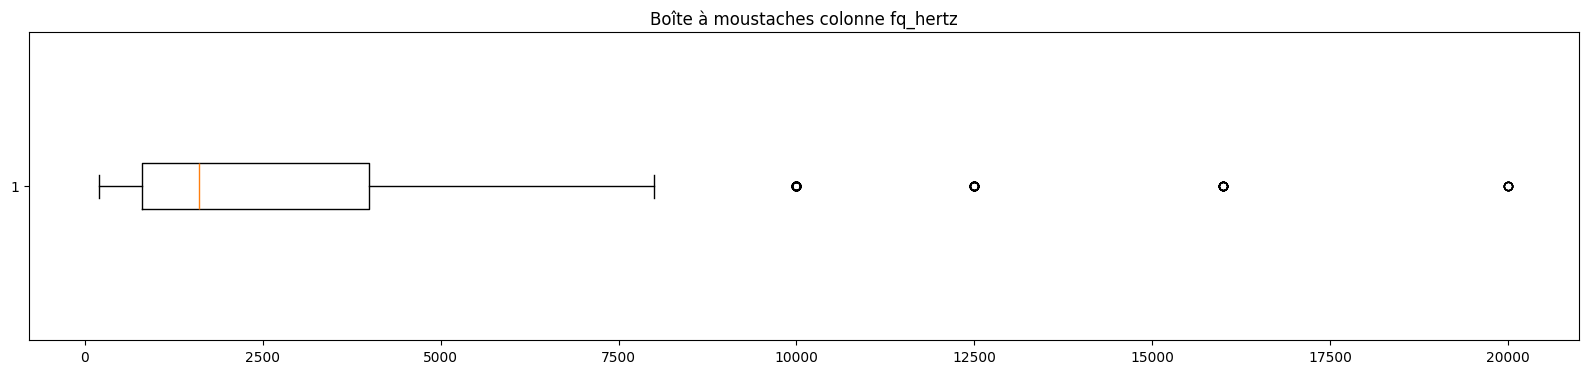

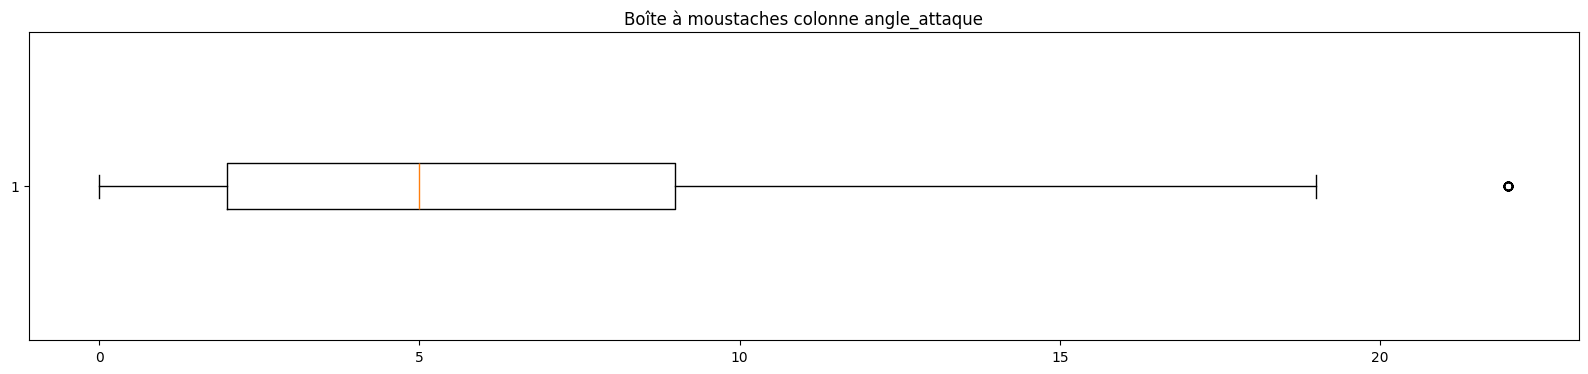

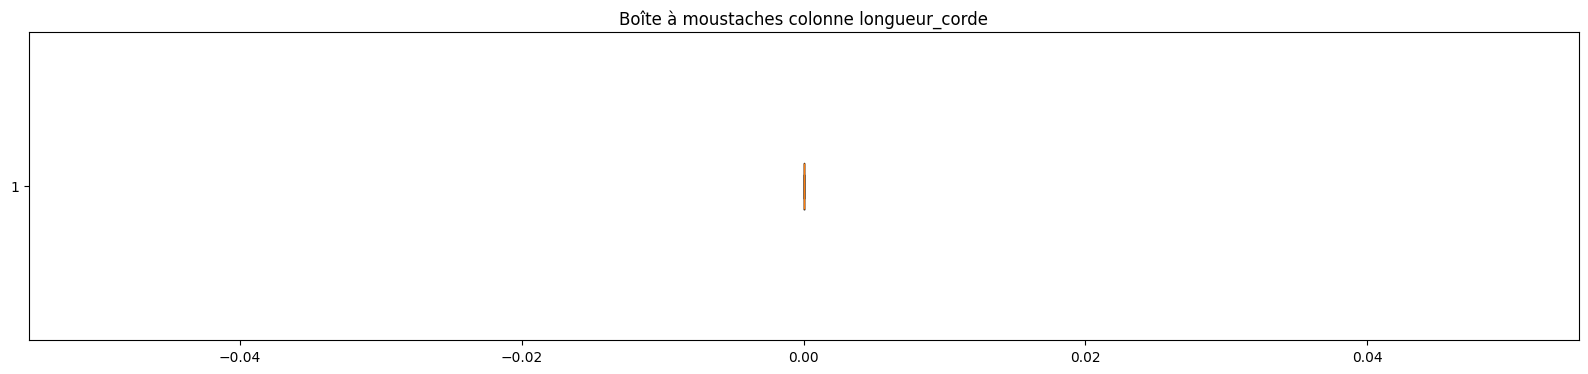

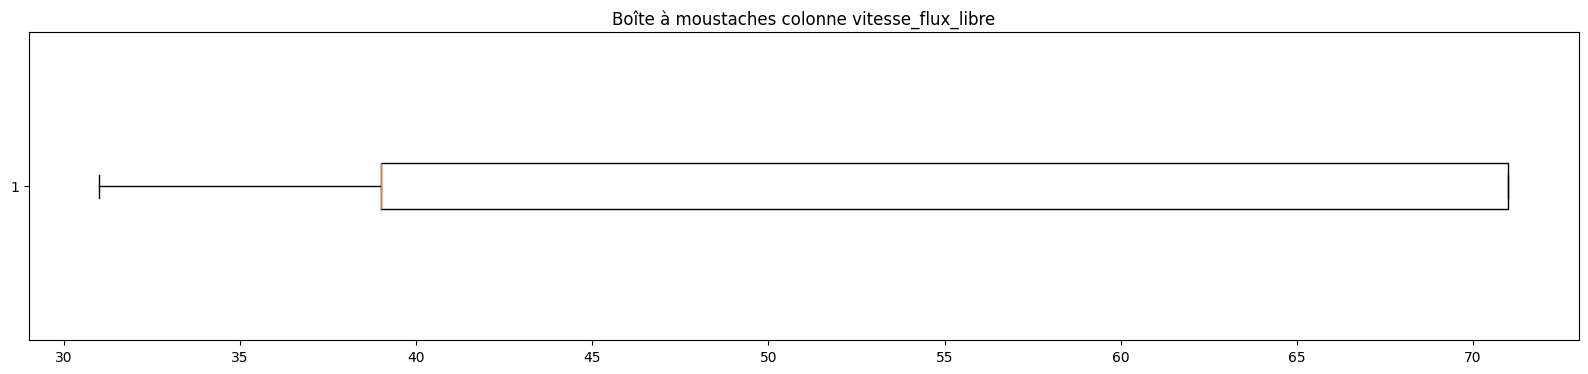

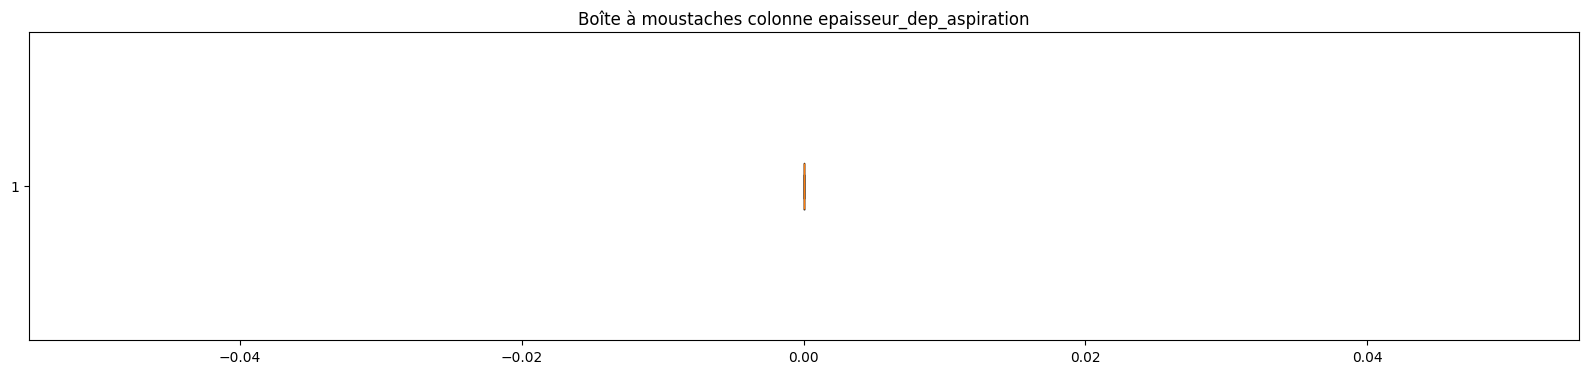

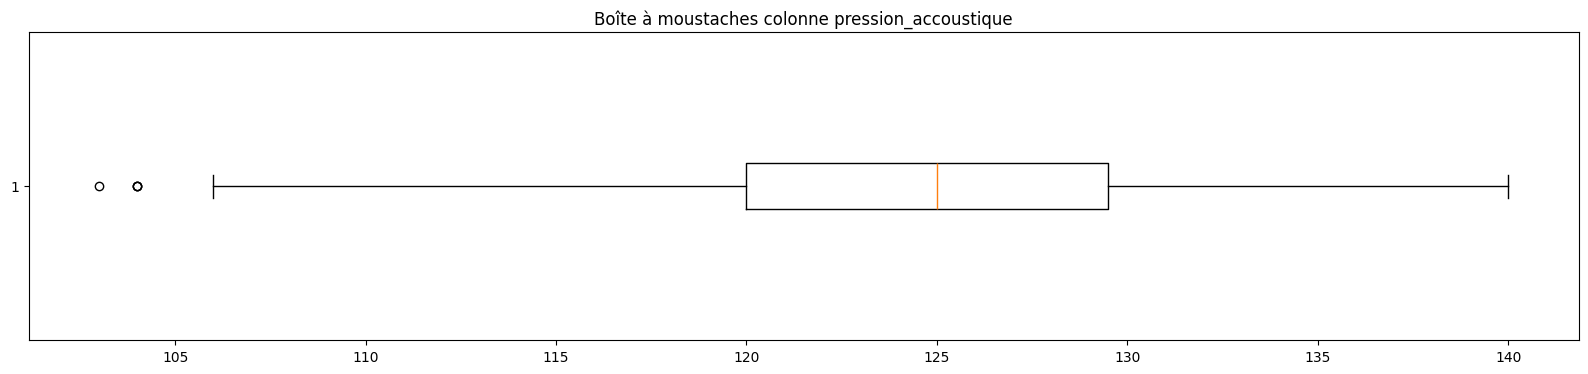

In [7]:
def remplacer_valeurs_aberrantes(data, column):
  valeurs = data[column].astype(float)

  # Calcul des quartiles
  q1 = valeurs.quantile(0.25)
  q3 = valeurs.quantile(0.75)

  # Calcul de la plage interquartiles
  iqr = q3 - q1

  # Calcul des limites des moustaches
  moustache_inferieure = q1 - 1.5 * iqr
  moustache_superieure = q3 + 1.5 * iqr

  # Remplacement des valeurs aberrantes par des valeurs entre le premier et le troisième quartile
  data.loc[data[column] < moustache_inferieure, column] = moustache_inferieure
  data.loc[data[column] > moustache_superieure, column] = moustache_superieure


def affichage_box_plot(column):
  valeurs = data[column].astype(int).tolist()
  plt.figure(figsize=(20, 4))
  plt.boxplot(valeurs, vert=False)
  plt.title(f'Boîte à moustaches colonne {column}')
  plt.show()

for column in data.columns:
    # remplacer_valeurs_aberrantes(data, column)
    affichage_box_plot(column)

# **=========================================================================================Exploratory_Data_Analysis_(EDA)=========================================================================================**

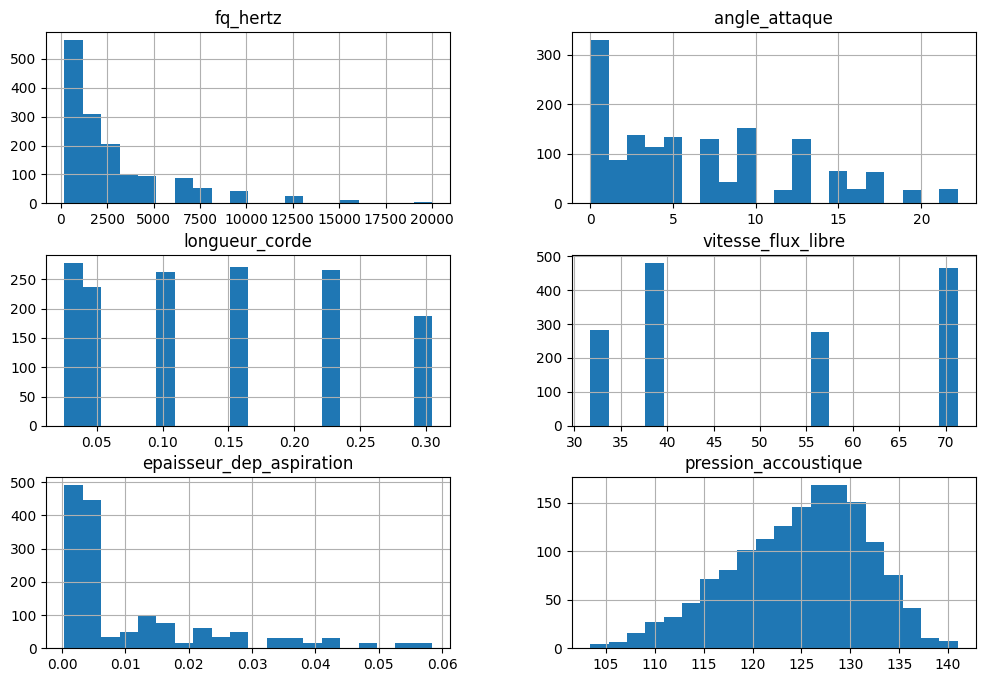

In [8]:
data.hist(bins=20, figsize=(12, 8))
plt.show()

# **Matrice de corrélation**

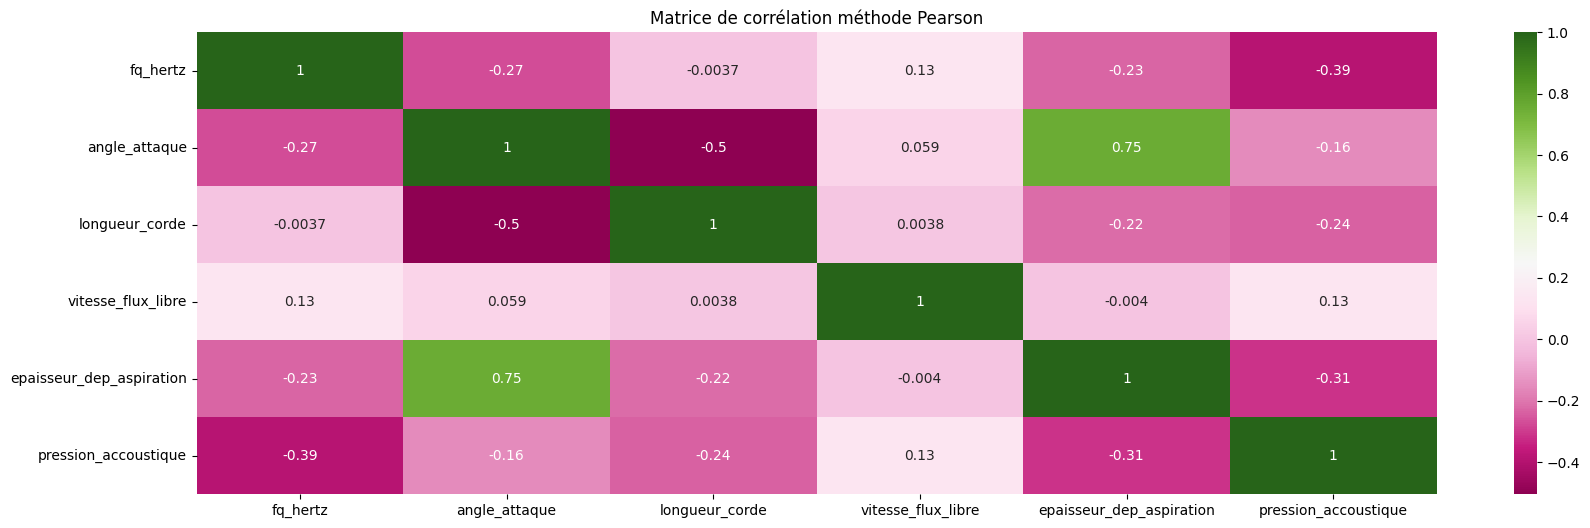

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
fq_hertz,1.0,-0.272765,-0.003661,0.133664,-0.230107,-0.390711


In [9]:
# variables
matrice = data.corr()

# graph
plt.figure(figsize=(20, 6))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation méthode Pearson')
plt.show()

print()
print()

# cible sur la target
display(matrice.head(1))

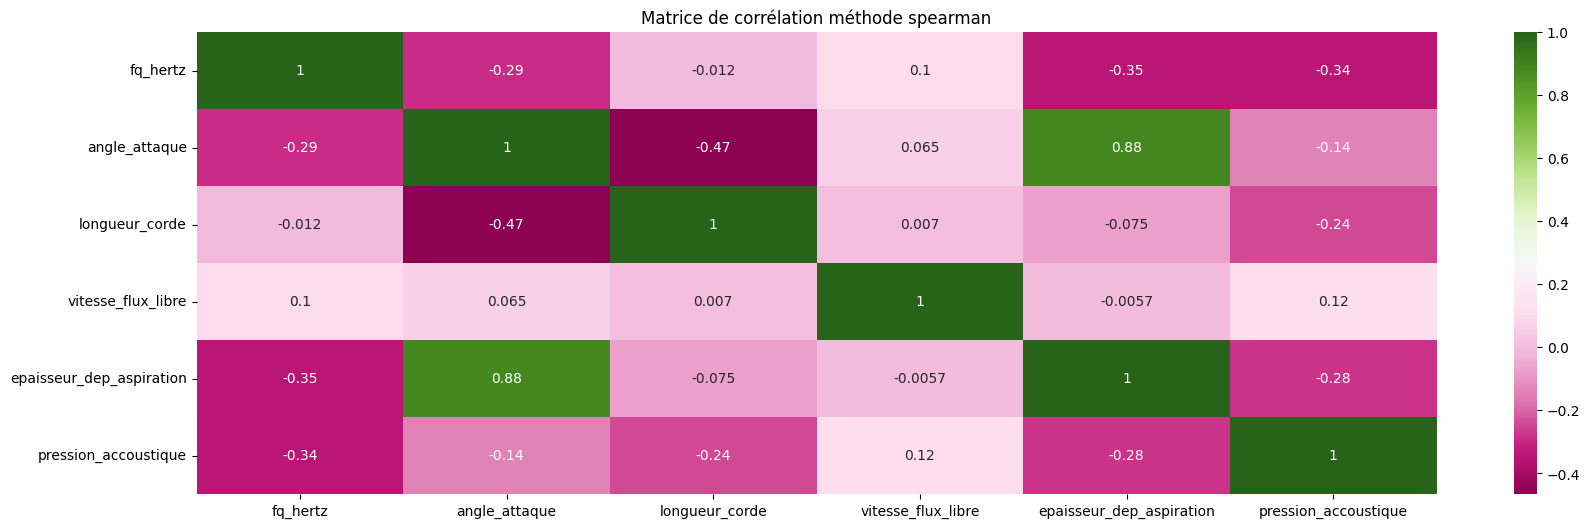

,fq_hertz,angle_attaque,longueur_corde,vitesse_flux_libre,epaisseur_dep_aspiration,pression_accoustique
fq_hertz,1.0,-0.293374,-0.012252,0.102771,-0.350656,-0.340783


In [10]:
# variables
matrice = data.corr(method='spearman')

# graph
plt.figure(figsize=(20, 6))
sns.heatmap(matrice, annot=True, cmap='PiYG')
plt.title('Matrice de corrélation méthode spearman')
plt.show()

print()
print()

# cible sur la target
display(matrice.head(1))

## Remarques
* -1 < valeurs matrice < 1
    - valeur proche de 1 --> corrélation forte
    - valeur proche de 0 --> corrélation faible
    - valeur proche de -1 --> corrélation négative
* valeurs > 0 --> corrélation positive : les deux variables augmentent ou diminuent ensemble
* valeurs < 0 --> corrélation négative : les deux variables augmentent ou diminuent dans des directions opposées
<br>
<br>

On remarque principalement que :
* il y a une corrélation positive entre l'angle d'attaque et l'épaisseur du déplacement coté aspiration
* il y a une corrélation négative entre l'angle d'attaque et la longueur de la corde
* il y a une corrélation négative entre la pression accoustique et la fréquence

**Corréalation de Pearson** : mesure la corrélation linéaire entre 2 variables continues

**Corrélation de Spearman** : évalue la corrélation monotone c'est à dire toutes corrélation croissante ou décroissante même si elle n'est pas linéaire

# **=====================================================================================================IA=====================================================================================================**

# **Preprossessing of data**

In [11]:
scaler = StandardScaler()

target = data['pression_accoustique']

preprocessed_data = data.drop(columns=[f'{target.name}']) # on enlève la variable cible

n_components = 2

# **PCA (Analyse en Composition Principales)**

In [12]:
def pca(n_components, data, variable, colorbar):
    var_pca = PCA(n_components = n_components)
    principal_components = var_pca.fit_transform(scaler.fit_transform(data))
    principal_df = pd.DataFrame(data = principal_components, columns=["PC1", "PC2"])

    plt.figure(figsize=(10, 8))
    plt.scatter(principal_df["PC1"], principal_df["PC2"], c = variable, cmap='turbo', alpha=0.5)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title(f"PCA : analyse en composantes principales")
    plt.colorbar(label = colorbar)
    plt.grid()
    plt.show()

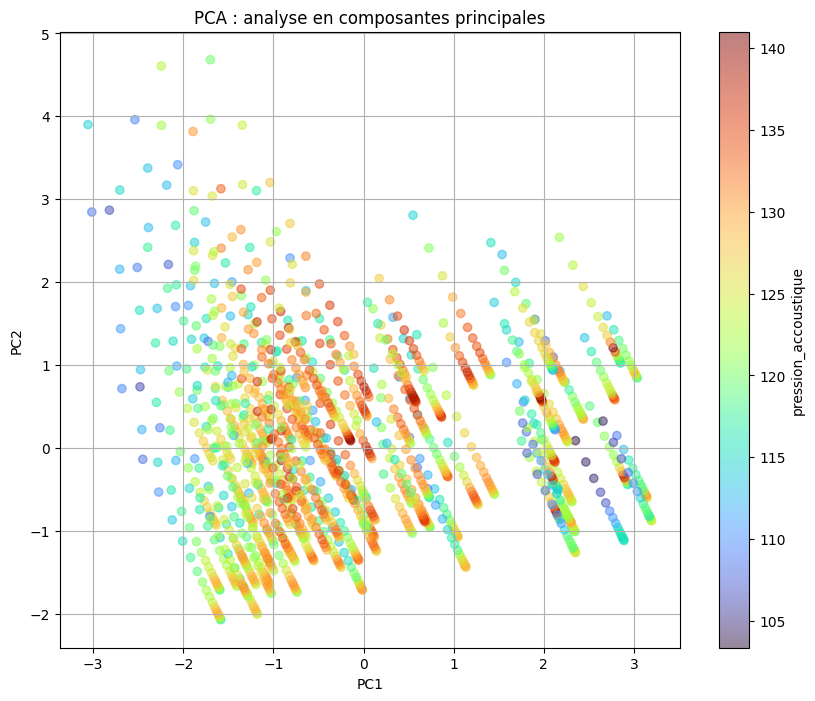

In [13]:
pca(n_components, preprocessed_data, target, target.name)

In [14]:
# Obtenir les valeurs propres
eigenvalues = PCA().fit(preprocessed_data).explained_variance_ratio_

print("{:<15} {:<2.6f} {:<15} {:<2.6f}".format("Valeurs propres PC1 :", eigenvalues[0], "Valeurs propres PC2 :", eigenvalues[1]))

Valeurs propres PC1 : 0.999973 Valeurs propres PC2 : 0.000024


## Remarques
PC1 et PC2 sont des combinaisons linéaires de des variables d'origine qui permettent de représenter les données d'une manière qui maximise la variance
<br>
--> But : réduire la dimensionnalité des données tout en préservant un maximum d'informations
<br>
<br>
**Observations :** Les données semblent être linéaires avec une variance élevée. PC1 est la composante qui explique le plus de variance : sa valeur propre (mesure de la variance de la composante) est de 99,9957% contre 0,0038% pour PC2.



# **TSNE (t-distributed stochastic neighbor embedding)**

In [15]:
def tsne(n_components, data, variable, colorbar):
    tsne = TSNE(n_components = n_components, perplexity = 25, random_state = 42)
    tsne_components = tsne.fit_transform(data)

    tsne_df = pd.DataFrame(data = tsne_components, columns = ["t-SNE1", "t-SNE2"])

    # graph
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_df["t-SNE1"], tsne_df["t-SNE2"], c = variable, alpha = 0.5)
    plt.xlabel("t-SNE1")
    plt.ylabel("t-SNE2")
    plt.title(f"t-SNE - Scatter Plot des composantes t-SNE")
    plt.colorbar(label = colorbar)
    plt.grid()
    plt.show()

Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  File "C:\Users\godai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


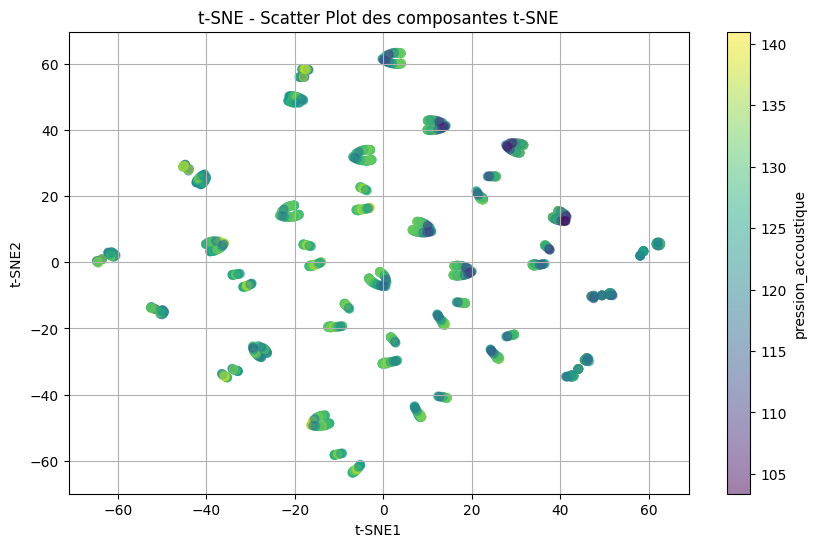

In [16]:
tsne(n_components, preprocessed_data, target, target.name)

## Remarques
* Les données regroupées indiquent des regroupements dans les données
* Les points éloignés peuvent être considérés comme des valeurs aberrantes

# **Self-Organizing Maps (SOM) ~~ cartes auto-organisatrices**

1. **Définition**
* Algorithme d’apprentissage non supervisé (pas de variable cible)
* Algorithme de classification (clustering) qui généralise l’algorithme d’apprentissage compétitif en rajoutant une structure de voisinage entre les classes
* Complexité : linéaire par rapport au nombre de données --> facile à programmer
* Réduire la dimensionnalité des données tout en conservant les structures et les relations entre les données --> facilite l'exploration des données
<br>
<br>
2. **Fonctionnement**
* Les cartes auto-organisatrices de **Kohonen** (1984) sont constituées d'une grille. Dans chaque nœud de la grille se trouve un « neurone »
* Chaque neurone est associé à un vecteur de poids initialisé aléatoirement.
* Chaque neurone calcule sa similarité avec les données d'entrée (mesures telles que la distance euclidienne)
* **Neurone gagnant** = neurone dont le vecteur de poids est le plus similaire aux données
* Les vecteurs de poids des neurones voisins du neurone gagnant sont ajustés pour devenir plus similaires aux données d'entrée --> forme des groupes / clusters
<br>
<br>
Les paramètres de SOM sont les suivants :
* x : som_grid_rows, est le nombre de lignes
* y : som_grid_columns, est le nombre de colonnes
* Sigma est le rayon du voisinage
* learning_rate
<br>
<br>
Utilisées pour visualiser des données telles que des images, des séquences temporelles ou des caractéristiques complexes.

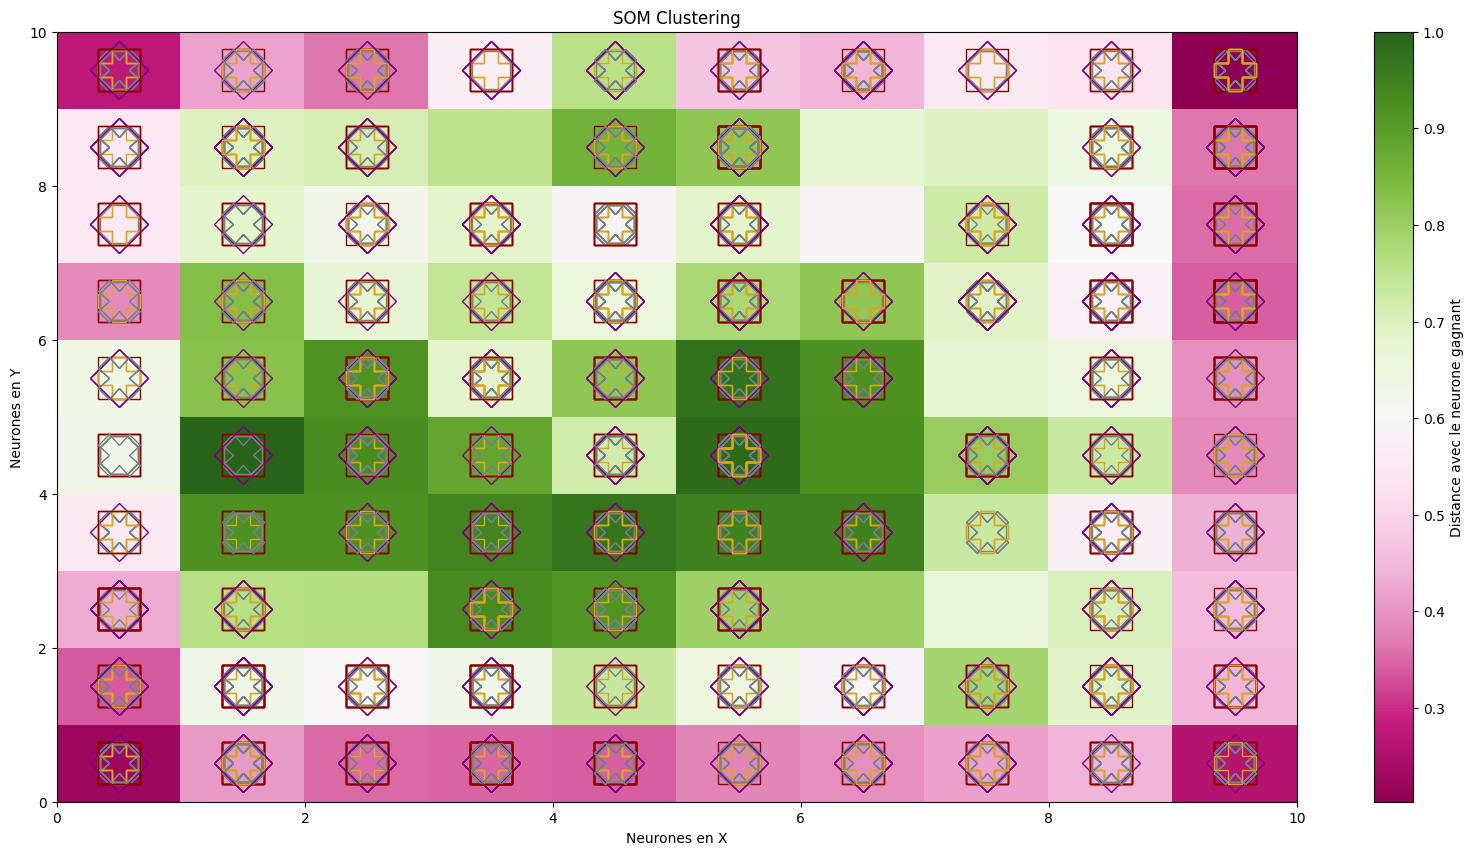

In [17]:
# Mise à l’échelle des x variables
min_max_scaler = MinMaxScaler() # utilisation de MinMaxScaler pour redimensionner les valeurs dans un interval de 0, 1 utile car tout dépend des distances
x = min_max_scaler.fit_transform(preprocessed_data)
pd.DataFrame(x)

som_dimens = (10, 10)
iterations = 20000
sigma = 1
learning_rate = 0.5

som = MiniSom(x = som_dimens[0],
              y = som_dimens[1],
              input_len = 5,
              sigma = sigma,
              learning_rate = learning_rate)

som.random_weights_init(x)

som.train_random(x, iterations)

# ==============================================================================

plt.figure(figsize=(20, 10))
plt.pcolor(som.distance_map().T, cmap='PiYG')
plt.colorbar(label="Distance avec le neurone gagnant")

colors = ['darkred', 'gray', 'purple', 'goldenrod', 'slategrey']
markers = ['s', '8', 'D', 'P', 'X']

for i, x in enumerate(x):
  index = int(target[i] % len(markers))
  winner = som.winner(x)
  plt.plot(winner[0] + 0.5,
           winner[1] + 0.5,
           markers[index],
           markeredgecolor = colors[index],
           markerfacecolor = 'None',
           markersize = 30)

plt.title('SOM Clustering')
plt.xlabel('Neurones en X')
plt.ylabel('Neurones en Y')
plt.show()

## Remarques
Les neurones représentent des clusters de données similaires :
<br>
* La majorité des noeuds ont des valeurs proches du neurone gagnant (couleur rose) --> les données sont rapprochées et se regroupent naturellement.
* Le noeud gagant est celui dont la valeur est minimale (couleur rose foncé) --> son vecteur de poids est le plus similaires aux données d'entrée.
<br>
Il représente le regroupement auquel les données d'entrée spécifiques sont les plus similaires.
<br>
<br>
* Les marqueurs sont utilisés pour indiquer à quelle catégorie chaque neurone est asocié après l'apprentissage de la carte.

# **=======================================================================================Supervised_Machine_Learning_Tasks=======================================================================================**

# **Mise à l'échelle des données**

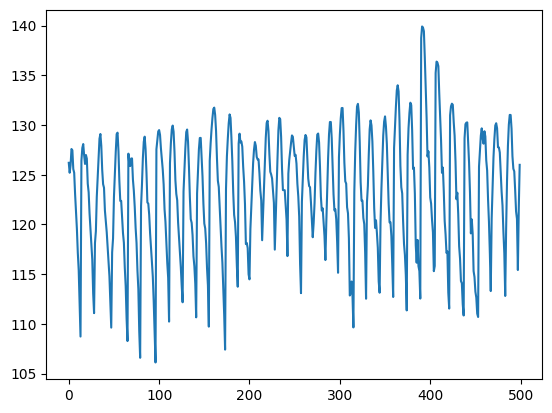

In [18]:
SEED = 1

X_train, X_test, y_train, y_test = train_test_split(preprocessed_data, target, test_size = 0.3, random_state = SEED)

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

plt.plot(target[:500])

# **Modèles individuels**

Tous sont des algorithmes d'apprentissage supervisé ou modèles individuels.
<br>
<br>

## **Random Forest**
Repose sur des arbres (arbres de décision)

**Fonctionnement :**
* Découpage du dataset en plusieurs sous-ensemble
* Entrainement d'un modèle sur chaque souis-ensemble
* Regroupement de tous les résultats du modèle
<br>
<br>

## **Extra Trees (Extra Trees Regressor)**
Similaire aux arbres de décision, mais avec une touche d'aléatoire

**Fonctionnement :**
* Découpe le dataset en plusieurs sous-ensembles
* Pour chaque sous-ensemble, il crée un arbre de décision avec des règles aléatoires pour réduire le surajustement
* Les résultats de tous les arbres sont combinés pour produire la prédiction finale
<br>
<br>

## **Decision Tree (Decision Tree Regressor)**
Crée un arbre de décision pour la prise de décision

**Fonctionnement :**
* Divise le dataset en fonction des caractéristiques, en essayant de minimiser l'impureté des nœuds
* L'arbre est utilisé pour prendre des décisions en suivant les chemins du haut vers le bas
* Peut être sensible au surajustement (overfitting) s'il est trop profond
<br>
<br>

## **XGBoost (XGBoost Regressor)**

* Algorithme spécialement conçu pour la régression et la classification
* Utilise un ensemble de modèles d'arbres de décision faibles (weak learners)

**Fonctionnement :**
* Les modèles sont formés de manière séquentielle, en corrigeant les erreurs des modèles précédents
* Utilise des techniques de régularisation pour éviter le surajustement
* Donne des performances élevées dans de nombreuses tâches d'apprentissage automatique
<br>
<br>

## **CatBoost (CatBoost Regressor)**
* Algorithme adapté aux données catégorielles
* Gère automatiquement les données catégorielles sans conversion en données numériques
* Utilise un grand nombre d'arbres de décision pour la prédiction
* Utilise un algorithme de gradient pour minimiser la perte
* Est conçu pour être efficace et précis, avec des paramètres par défaut bien ajustés
<br>
<br>

## **LightGBM (LightGBM Regressor)**

* Algorithme conçu pour être rapide et précis
* Utilise un algorithme de gradient pour l'entraînement des arbres
* Utilise une stratégie de division en feuille (Leaf-Wise) pour accélérer la convergence
* Peut gérer des datasets volumineux et dispose d'options de parallélisme
* Dispose de paramètres ajustables pour optimiser les performances en fonction des besoins


In [19]:
def calculateModelsWithDifferentsMetrics(models, X_train, X_test, y_train, y_test):
    measures = [d2_score, MAE, MSE, r2_score, 'RMSE']

    results = []

    for model_name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        model_results = [model_name]

        for measure in measures:
          if measure == 'RMSE':
            result = np.sqrt(MSE(y_test, y_pred))
            model_results.append(result)
          else :
            result = measure(y_test, y_pred)
            model_results.append(result)

        results.append(model_results)
    return results

In [20]:
def graphPerformanceModels(results):
    metrics = ["D2", "MAE", "MSE", "R2", "RMSE"]
    model_names = [row[0] for row in results]
    values = [[row[i] for row in results] for i in range(1, len(results[0]))]  # Sélectionne toutes les valeurs

    bar_width = 0.2
    index = np.arange(len(model_names))

    plt.figure(figsize=(12, 4))

    for i, value in enumerate(values):
        plt.bar(index + i * bar_width, value, bar_width, label = metrics[i])  # Utilisation de la première ligne pour les noms

    plt.xlabel('Modèles')
    plt.ylabel('Valeurs')
    plt.title('Performances des modèles')
    plt.legend()
    plt.xticks(index + 1.5 * bar_width, model_names, rotation = 45)

    plt.show()

In [21]:
def affichePerformanceModels(results):
    print("{:<15} \t {:<10} \t {:<10} \t {:<10} \t {:<10} \t {:<10}".format("Techniques", "D2", "MAE", "MSE", "R2", "RMSE"))
    print("______________________________________________________________________________________________")
    for row in results:
        print("{:<15} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f}".format(*row))
        print("______________________________________________________________________________________________")

In [22]:
models_individuels = [
    ("Random Forest", RandomForestRegressor(random_state = SEED, verbose = 0)),
    ("Extra Trees", ExtraTreesRegressor(random_state = SEED, verbose = 0)),
    ("Decision Tree", DecisionTreeRegressor(random_state = SEED)),
    ("XGBoost", XGBRegressor(random_state = SEED)),
    ("CatBoost", CatBoostRegressor(random_seed = SEED, verbose = 0)),
    ("LightGBM", LGBMRegressor(random_state = SEED, verbose = 0))
]

In [23]:
results_models = calculateModelsWithDifferentsMetrics(models_individuels, X_train, X_test, y_train, y_test)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


Techniques      	 D2         	 MAE        	 MSE        	 R2         	 RMSE      
______________________________________________________________________________________________
Random Forest   	 0.762      	 1.335      	 3.398      	 0.927      	 1.843     
______________________________________________________________________________________________
Extra Trees     	 0.810      	 1.071      	 2.218      	 0.952      	 1.489     
______________________________________________________________________________________________
Decision Tree   	 0.640      	 2.021      	 7.631      	 0.836      	 2.762     
______________________________________________________________________________________________
XGBoost         	 0.798      	 1.134      	 2.362      	 0.949      	 1.537     
______________________________________________________________________________________________
CatBoost        	 0.816      	 1.032      	 2.144      	 0.954      	 1.464     
_______________________________________

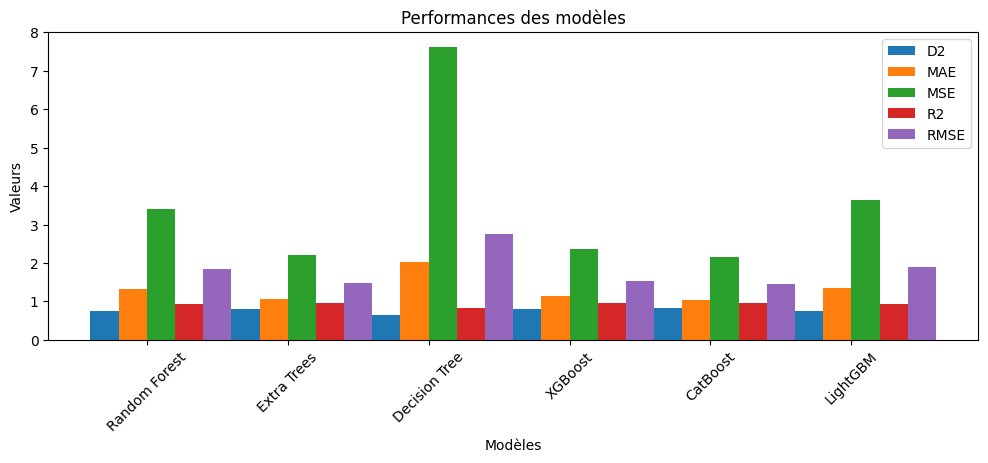

In [24]:
affichePerformanceModels(results_models)
graphPerformanceModels(results_models)

* **MSE** (Mean Squared Error) - Erreur quadratique moyenne. Doit être proche de 0 : prédictions du modèle sont très proches des valeurs réelles
<br>
<br>
* **MAE** (Mean Absolute Error) - Erreur absolue moyenne. Doit être proche de 0 : les écart entre les prédictions et les valeurs réelles sont très faibles
<br>
<br>
* **RMSE** (Root Mean Squared Error) - Erreur quadratique moyenne de la racine carrée. Doit être proche de 0 : même principe, une valeur proche de 0 indique un taux d'erreur dans les prédictions très faible
<br>
<br>
* **R-squared** (R²) - Coefficient de détermination : proportion de la variance dans la variable cible. Doit être proche de 1 : le modèle explique parfaitement la variance des données

## Remarques
Le meilleur modèle est Extra Trees : les valeurs pour MAE, MSE, RMSE sont proche de 0 tandis que la valeur pour R2 est la plus proche de 1.
<br>
Cela signifie que le modèle explique parfaitement la variance des données tandis que le taux d'erreur commise est très faible.

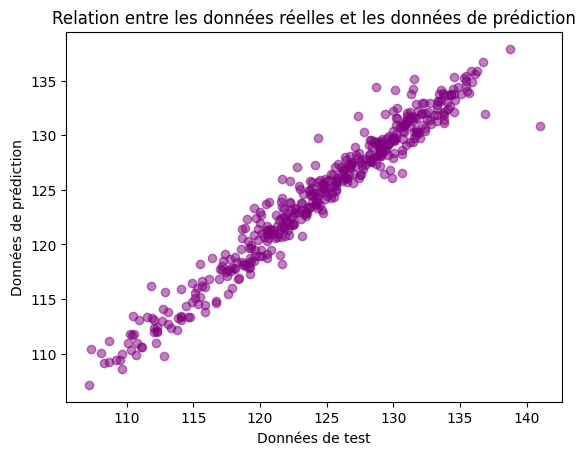

In [25]:
catBoost_model = CatBoostRegressor(random_state = SEED, verbose = 0)
catBoost_model.fit(X_train, y_train)

plt.scatter(y_test, catBoost_model.predict(X_test), color='purple', alpha = 0.5)
plt.xlabel(xlabel = 'Données de test')
plt.ylabel(ylabel = 'Données de prédiction')
plt.title(label = 'Relation entre les données réelles et les données de prédiction')
plt.show()

## Remarques
* Les données de prédictions et les données originelles forment une ligne avec quelque points en dehors
* On en déduit que les valeurs de prédiction sont presques similaires à celles d'origine

# **Ajustement des hyparamètres du modèle individuel**

* Trouver les meilleurs valeurs pour les paramètres de configuration (complexité du modèle, capacité de généralisation, taux d'apprentissage, nombre d'itération, ...)
* Permet d'améliorer les performances du modèle
<br>
<br>

### **Recherche en grille (Grid Search) :**

* La recherche en grille consiste à spécifier une liste de valeurs pour chaque hyperparamètre que vous souhaitez ajuster.
* Elle examine toutes les combinaisons possibles de ces valeurs.
* Cela signifie que la recherche en grille peut être très coûteuse en termes de temps de calcul, en particulier si vous avez de nombreux hyperparamètres et un grand nombre de valeurs à tester.
* Elle garantit de trouver les meilleurs hyperparamètres, mais cela peut prendre beaucoup de temps.
<br>

### **Recherche aléatoire (Random Search) :**

* La recherche aléatoire consiste à spécifier une distribution de probabilité pour chaque hyperparamètre, plutôt que des valeurs spécifiques.
* Elle échantillonne aléatoirement les hyperparamètres dans ces distributions.
* Par conséquent, la recherche aléatoire explore un espace d'hyperparamètres plus large en moins de temps que la recherche en grille.
* Cependant, il n'est pas garanti de trouver les meilleurs hyperparamètres, car certains jeux d'hyperparamètres peuvent ne jamais être échantillonnés.
<br>

### **Optimisation bayésienne :**

* L'optimisation bayésienne est une méthode plus sophistiquée qui utilise des modèles probabilistes pour estimer les performances du modèle en fonction des hyperparamètres.
* Elle utilise ces estimations pour décider quelles valeurs d'hyperparamètres explorer ensuite.
* L'optimisation bayésienne est plus efficace que la recherche en grille et la recherche aléatoire, car elle tient compte des informations accumulées au fil des itérations pour cibler les hyperparamètres les plus prometteurs.
* Elle est particulièrement utile lorsque l'ajustement des hyperparamètres est coûteux en temps, car elle nécessite moins d'expérimentations.

In [26]:
def hyperparametersTuning(models, X_train, X_test, y_train, y_test):

  hyperparameters_results = []

  techniques = []

  for model_name, model, params in models:
    # techniques.append((model_name, model, 'GridSearchCV', GridSearchCV(model, params, scoring='neg_mean_squared_error'))),
    # techniques.append((model_name, model, 'RandomizedSearchCV', RandomizedSearchCV(model, params, n_iter=10, scoring='neg_mean_squared_error', random_state=SEED))),
    techniques.append((model_name, model, 'BayesSearchCV', BayesSearchCV(model, params, n_iter=10, scoring='neg_mean_squared_error', random_state=SEED)))

  for model_name, model, technique_name, technique in techniques:
    technique.fit(X_train, y_train)
    best_params = technique.best_params_
    print(f'{technique_name} meilleurs hyperparamètres pour {model_name} : {best_params}')

    # Modèle ajusté avec les hyperparamètres
    model_tuned = model.set_params(**best_params)
    model_tuned.fit(X_train, y_train)
    y_pred_tuned = model_tuned.predict(X_test)
    # Calcul des métriques pour les modèles
    mae_tuned = MAE(y_test, y_pred_tuned)
    mse_tuned = MSE(y_test, y_pred_tuned)
    r2_tuned = r2_score(y_test, y_pred_tuned)
    rmse_tuned = np.sqrt(mse_tuned)

    hyperparameters_results.append([technique_name, mae_tuned, mse_tuned, r2_tuned, rmse_tuned])

  return hyperparameters_results

In [27]:
params = {
    'n_estimators': (100, 500, 'uniform')
}
model = [
    ("CatBoost", CatBoostRegressor(random_state = SEED, verbose = 0), params)
]

hyperparams_tuning_results = hyperparametersTuning(model, X_train, X_test, y_train, y_test)

BayesSearchCV meilleurs hyperparamètres pour CatBoost : OrderedDict([('n_estimators', 487)])


In [28]:
print("{:<15} \t {:<10} \t {:<10} \t {:<10} \t {:<10}".format("Techniques", "MAE", "MSE", "R2", "RMSE"))
print("______________________________________________________________________________________________")
for row in hyperparams_tuning_results:
    print("{:<15} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f} \t {:<10.3f}".format(*row))
    print("______________________________________________________________________________________________")

Techniques      	 MAE        	 MSE        	 R2         	 RMSE      
______________________________________________________________________________________________
BayesSearchCV   	 1.075      	 2.344      	 0.950      	 1.531     
______________________________________________________________________________________________


## Remarques
L'ajustement des hyperparamètres ne change pas significativement les résultats du modèle Extra Trees (légère diminution, égalité ou légère augmentation).

# **Modèles d'ensemble**

## **Bagging**
<br>
Bagging : Boostrap aggregating
<br>

* Utilise une technique connue sous le nom de Bootstrap

* Réduit la variance des modèles individuels dans l'ensemble
<br>
<br>

## **Staking**
<br>
<br>

## **Voting**
Voting : Méthode d'ensemble utilisée en apprentissage automatique pour combiner les prédictions de plusieurs modèles de maching learning différents

In [29]:
best_params_catboost = {
    'n_estimators': 487,
}

catboost_model = CatBoostRegressor(random_state = SEED, verbose = 0)
catboost_tuned = CatBoostRegressor(random_state = SEED, verbose = 0, **best_params_catboost)
results_techniques = []

In [30]:
models_ensemble = [
    ("BaggingRegressor", BaggingRegressor(estimator = catboost_model)),
    ("B.R hyperparamètres", BaggingRegressor(estimator = catboost_tuned)),

    ("StackingRegressor", StackingRegressor([('catboost_model', catboost_model)])),
    ("S.R hyperparamètres", StackingRegressor(estimators = [('catboost_tuned', catboost_tuned)])),

    ("VotingRegressor", VotingRegressor([('catboost_model', catboost_model)])),
    ("V.R hyperparamètres", VotingRegressor(estimators = [('catboost_tuned', catboost_tuned)]))
]

In [31]:
results_techniques = calculateModelsWithDifferentsMetrics(models_ensemble, X_train, X_test, y_train, y_test)

Techniques      	 D2         	 MAE        	 MSE        	 R2         	 RMSE      
______________________________________________________________________________________________
BaggingRegressor 	 0.799      	 1.131      	 2.589      	 0.945      	 1.609     
______________________________________________________________________________________________
B.R hyperparamètres 	 0.792      	 1.171      	 2.767      	 0.941      	 1.664     
______________________________________________________________________________________________
StackingRegressor 	 0.816      	 1.032      	 2.134      	 0.954      	 1.461     
______________________________________________________________________________________________
S.R hyperparamètres 	 0.809      	 1.076      	 2.333      	 0.950      	 1.528     
______________________________________________________________________________________________
VotingRegressor 	 0.816      	 1.032      	 2.144      	 0.954      	 1.464     
____________________________

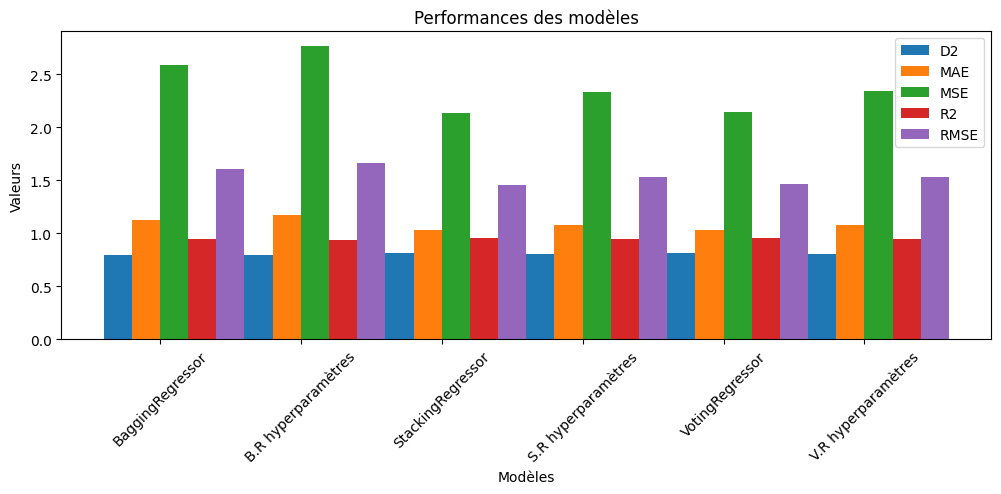

In [32]:
affichePerformanceModels(results_techniques)
graphPerformanceModels(results_techniques)

## Remarque

On constate que StackingRegressor avec un ExtraTreesRegressor ajusté avec des hyperparamètres donne de meilleurs résultats.
<br>
<br>
Les résultats montrent que StackingRegressor obtient de meilleures performances lorsqu'il prend en paramètre un ExtraTreesRegressor préalablement ajusté avec des hyperparamètres optimisés.

# **Score d'importance**

* Évaluer l'influence de chaque variable
* Ces scores mesurent à quel point chaque variable contribue à la performance globale du modèle
<br>
<br>

### **Modèles individuels**
<br>
Les scores donnent une idée de la contribution de chaque caractéristiques à la prédiction du modèle
<br>

**Gini Importance**
* « diminution moyenne de l’impureté »
* Définie comme la diminution totale de l’impureté du nœud qui est pondérée par la probabilité d’atteindre ce nœud
* Méthode moyennée sur tous les arbres de l’ensemble
<br>
<br>

**Modèles d'ensemble**
<br>
Les scores donnent une idée de la contribution relative de chaque caractéristique à la performance globale de l'ensemble

In [33]:
def calculateImportanceIndividualModels(models, preprocessed_data, X_train, y_train):

    feature_importances = [0] * len(preprocessed_data.columns)
    feature_names = preprocessed_data.columns

    for model_name, model in models:
        model.fit(X_train, y_train)

        for index, importance in enumerate(model.feature_importances_):
            feature_importances[index] += importance

    total_importance = sum(feature_importances)
    normalized_importances = [importance / total_importance for importance in feature_importances]

    return [normalized_importances, feature_names]

## Remarque
Calcul des scores d'importance des modèles d'ensemble en utilisant la technique de permutation

In [34]:
def calculateImportanceEnsembleModels(models, X_train, X_test, y_train, y_test, metric=MAE, num_permutations=20):

    feature_importances = [0] * len(preprocessed_data.columns)
    feature_names = preprocessed_data.columns # for est in model.estimators_ :  est.feature_importances_

    for model_name, model in models:

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        baseline_score = metric(y_test, y_pred)

        for feature in range(len(feature_names)):
            permuted_scores = []

            for _ in range(num_permutations):
                X_permuted = X_test.copy()
                X_permuted[:, feature] = np.random.permutation(X_permuted[:, feature])
                y_pred = model.predict(X_permuted)
                permuted_score = metric(y_test, y_pred)
                permuted_scores.append(permuted_score)

            feature_importances[feature] += baseline_score - np.mean(permuted_scores)
    total_importance = sum(feature_importances)
    normalized_importances = [importance / total_importance for importance in feature_importances]

    return [normalized_importances, feature_names]

In [35]:
def afficheImportanceCaracteristiques(feature_importances, feature_names):
    palette = ['red', 'steelblue', 'seagreen', 'mediumorchid', 'pink']

    plt.figure(figsize=(20, 6))
    plt.title("Importance des caractéristiques")
    plt.barh(range(len(feature_importances)), [importance for importance in feature_importances], align="center", color=palette)
    plt.yticks(range(len(feature_importances)), [name for name in feature_names])
    plt.tight_layout()
    plt.show()

In [36]:
importance_models_individuels = calculateImportanceIndividualModels(models_individuels, preprocessed_data, X_train, y_train)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.


In [37]:
importance_models_ensemble = calculateImportanceEnsembleModels(models_ensemble, X_train, X_test, y_train, y_test)

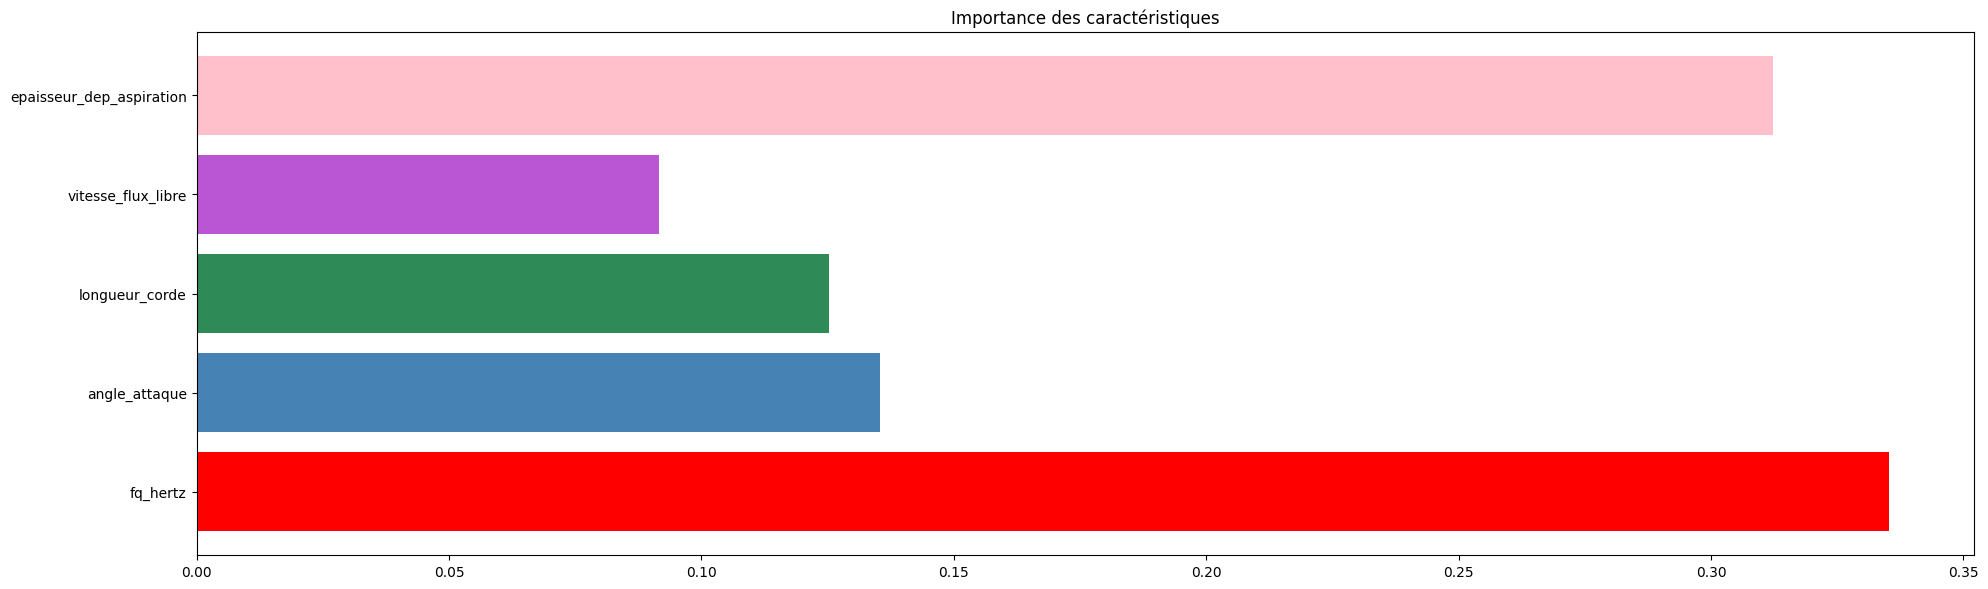

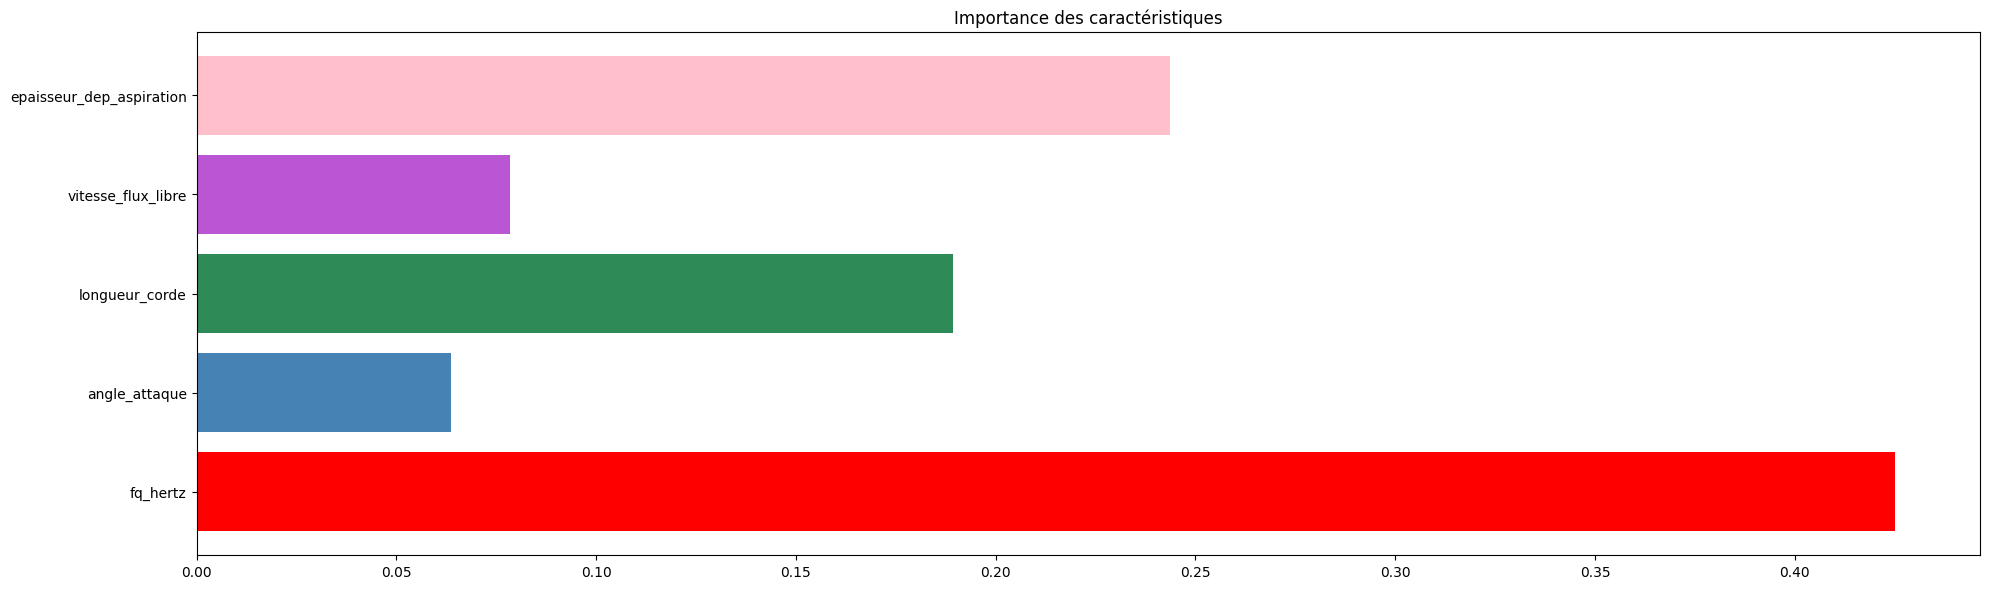

In [38]:
afficheImportanceCaracteristiques(importance_models_individuels[0], importance_models_individuels[1])
afficheImportanceCaracteristiques(importance_models_ensemble[0], importance_models_ensemble[1])

# **Explication des décisions prises par les modèles**

In [39]:
def calculateShapValues(models, X_train, y_train, X_test, type = "individual"):

    for model_name, model in models:
        model.fit(X_train, y_train)

        if type == "individual":
            explainer = shap.TreeExplainer(model)

        else :
            function = model.predict
            explainer = shap.KernelExplainer(function, X_train)

        shap_values = explainer.shap_values(X_test)

        print(model_name)
        shap.summary_plot(shap_values, X_test)

Random Forest


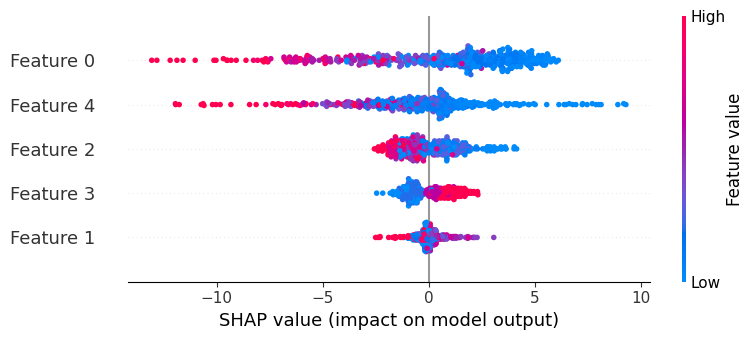

Extra Trees


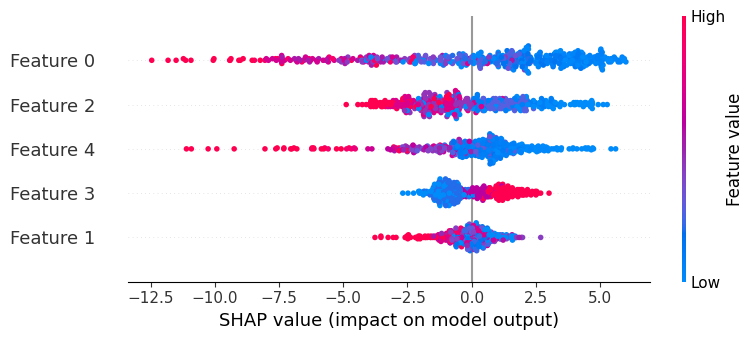

Decision Tree


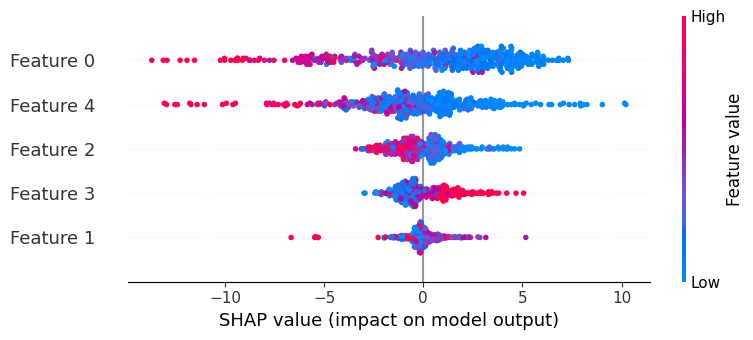

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
[14:19:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0cec3277c4d9d0165-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


XGBoost


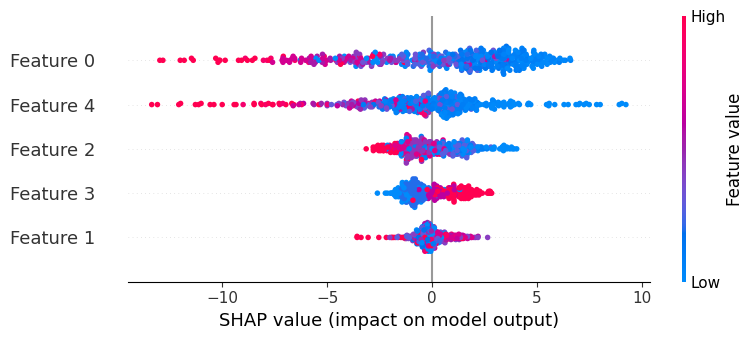

CatBoost


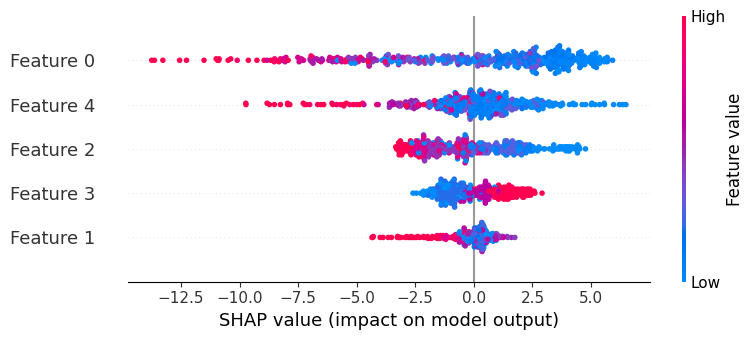

LightGBM


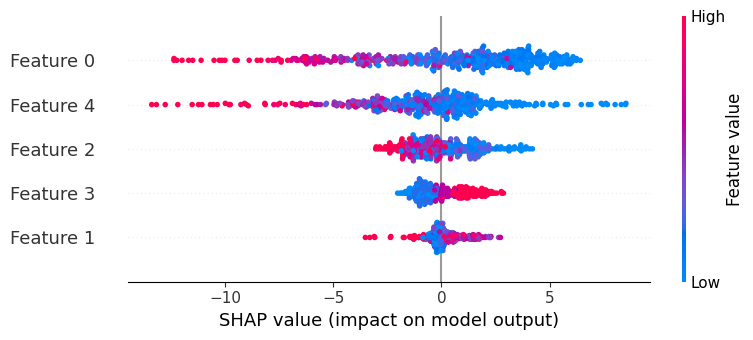

In [40]:
calculateShapValues(models_individuels, X_train, y_train, X_test)

Using 1052 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 451/451 [15:00<00:00,  2.00s/it]    

BaggingRegressor hyperparamètres


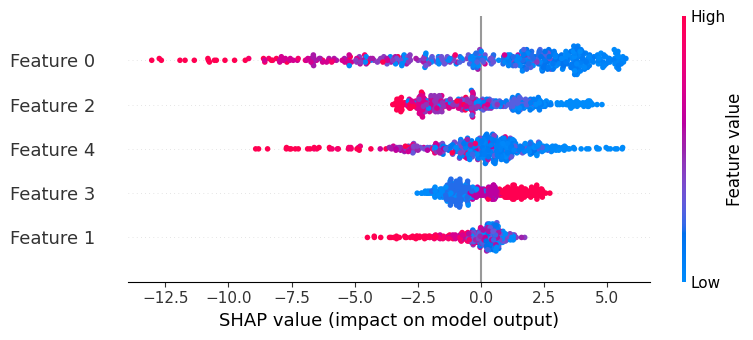

Using 1052 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 451/451 [03:28<00:00,  2.16it/s]


StackingRegressor hyperparamètres


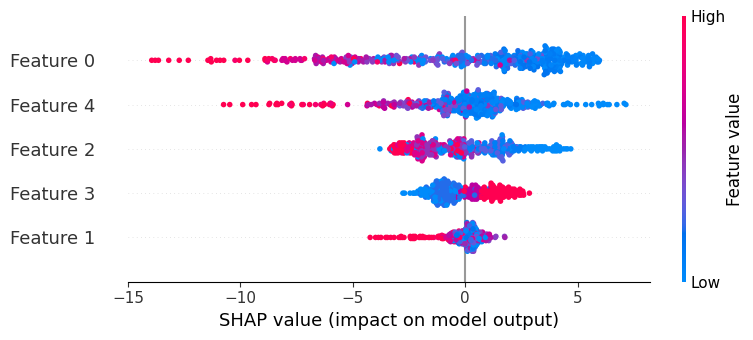

Using 1052 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 451/451 [16:42<00:00,  2.22s/it]   

VotingRegressor hyperparamètres


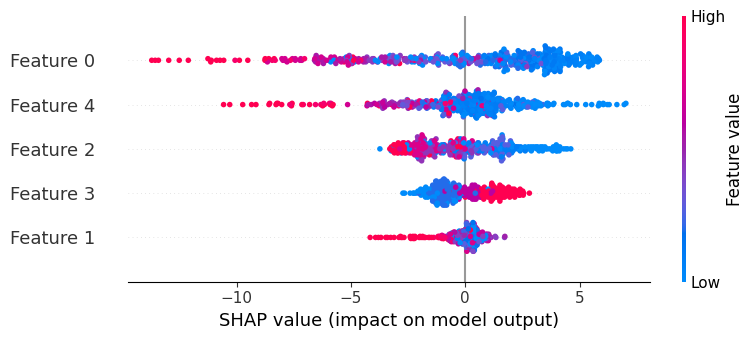

In [41]:
models_ensemble_ajustes = [
    ("BaggingRegressor hyperparamètres", BaggingRegressor(estimator = catboost_tuned)),
    ("StackingRegressor hyperparamètres", StackingRegressor(estimators = [('catboost_tuned', catboost_tuned)])),
    ("VotingRegressor hyperparamètres", VotingRegressor(estimators = [('catboost_tuned', catboost_tuned)]))
]
calculateShapValues(models_ensemble_ajustes, X_train, y_train, X_test, "ensemble")

# **Clustering**

## **K-means :**
* Regroupe les données disponibles en essayant de séparer les échantillons en K groupes de variance égale
* Minimiser le critère d' inertie (WCSS) ou somme des carrés intra-cluster
* Nécessite que le nombre de clusters soit spécifié
<br>

**Interprétation**
* Diminution à mesure que le nombre de clusters augmente
* Le nombre optimal de clusters est généralement choisi au niveau où la diminution du WCSS est moins significative
<br>
<br>

## **Modèle de mélange gaussien (GMM) :**
* Algorithme basé sur des distributions gaussiennes pour modéliser les clusters
* Utilisation de métriques tels que :
    * l'AIC (Critère d'information d'Akaike)
    * le BIC (Critère d'information bayésien)
* Ces mesures permettent de choisir le nombre optimal de clusters
<br>

**Interprétation**
* Diminution à mesure que le nombre de clusters augmente
* Préférable de choisir le nombre de clusters qui correspond au point le plus bas de ces courbes
<br>
<br>

## **DBSCAN (Density-Based Spatial Clustering of Applications with Noise) :**
* Algorithme basé sur la densité
* Coefficient de silhouette : métrique courante utilisée pour évaluer le nombre optimal de clusters
<br>
<br>

## **Clustering hierarchique :**
* La découpe du dendrogramme peut indiquer le nombre de clusters
* Utilisation de mesures comme :
    * l'indice de Calinski-Harabasz
    * l'indice Davies-Bouldin
<br>

**Interprétation**
* Augmentation à mesure que le nombre de clusters augmente
* Le nombre optimal de clusters est choisi en fonction du point où la fusion des clusters commence à être significativement élevée

In [42]:
def wcss(matrix, start, stop):
    wcss = []
    for i in range(start, stop):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter = 300, n_init = 10, random_state = SEED)
        kmeans.fit(matrix)
        wcss.append(kmeans.inertia_)
    return wcss

def gmm(matrix, start, stop):
    aic = []
    bic = []
    for i in range(start, stop):
        instance_gmm = GaussianMixture(n_components = i, random_state = SEED)
        instance_gmm.fit(matrix)
        aic.append(instance_gmm.aic(matrix))
        bic.append(instance_gmm.bic(matrix))
    return (aic, bic)

def dbscan(matrix, start, stop):
    silhouette_scores = []
    for eps in range(start, stop):
        dbscan = DBSCAN(eps = eps, min_samples = 123)
        labels = dbscan.fit_predict(matrix)
        silhouette_scores.append(silhouette_score(matrix, labels))
    return silhouette_scores

def hierarchical_metrics(matrix, start, stop):
    silhouette_scores = []
    for n_clusters in range(start, stop):
        model = AgglomerativeClustering(n_clusters=n_clusters)
        labels = model.fit_predict(matrix)
        silhouette_scores.append(silhouette_score(matrix, labels))
    return silhouette_scores


In [43]:
def numberOfClusters(technique_name, technique_result, min, max):
    plt.figure(figsize=(8, 6))

    if len(technique_result) == 2 :
        plt.plot(range(1, len(technique_result[0]) + 1), technique_result[0], marker='o', linestyle='--', label='AIC')
        plt.plot(range(1, len(technique_result[1]) + 1), technique_result[1], marker='o', linestyle='--', label='BIC')
        plt.legend()
    else :
        plt.plot(range(1, len(technique_result) + 1), technique_result, marker='o', linestyle='--')

    plt.xlabel('Nombre de clusters')
    plt.ylabel('Valeurs')

    plt.title(f'Résultats de l\'algorithme de clustering {technique_name}')
    plt.show()

In [44]:
matrix = scaler.fit_transform(preprocessed_data)
start = 1
stop = 11

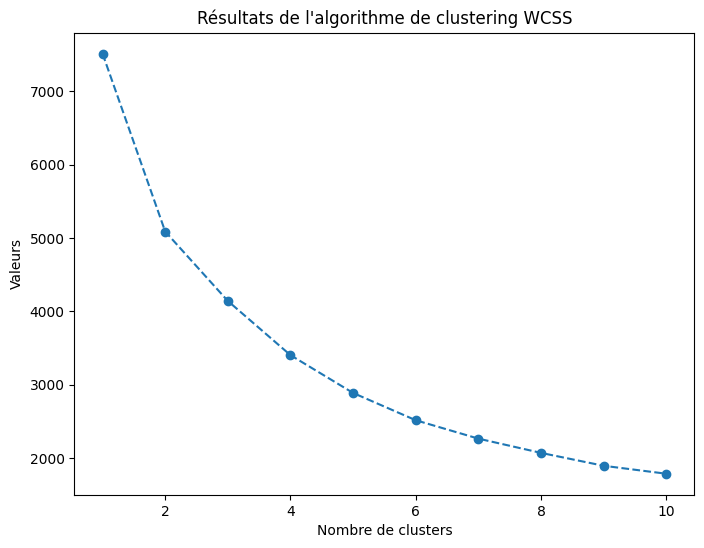

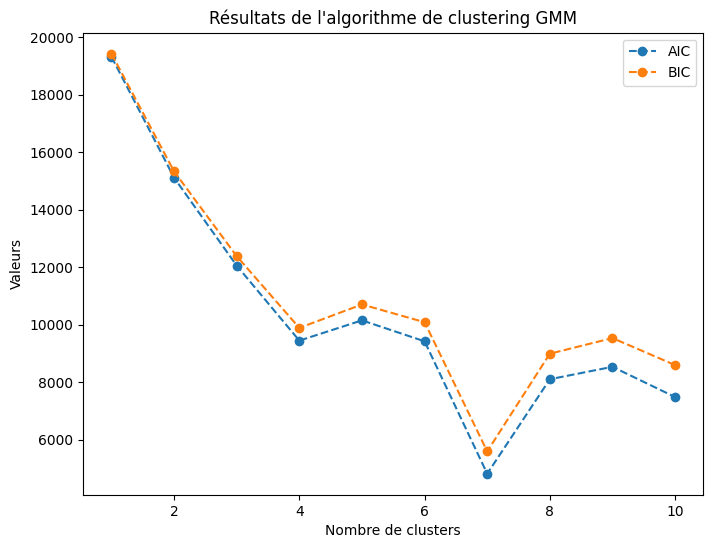

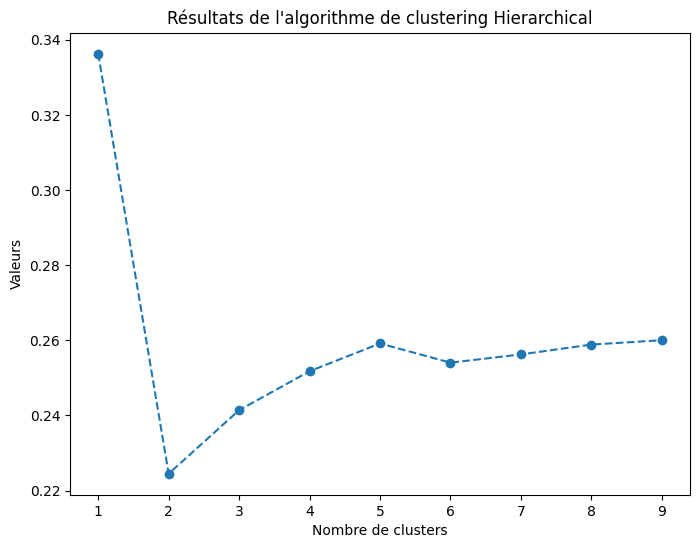

In [45]:
numberOfClusters(technique_name = 'WCSS', technique_result = wcss(matrix, start, stop), min = start, max = stop)
numberOfClusters(technique_name = 'GMM', technique_result = gmm(matrix, start, stop), min = start, max = stop)
# numberOfClusters(technique_name = 'DBSCAN', technique_result = dbscan(matrix, start, stop), min = start, max = stop)
numberOfClusters(technique_name = 'Hierarchical', technique_result = hierarchical_metrics(matrix, 2, stop), min = 2, max = stop)

## Remarques
**WCSS :** diminution marginale du WCSS autour de 3 clusters

**GMM :** le nombre de clusters correspond au point le plus bas de ces courbes aux alentours de 7 clusters

**Hierarchical :** la fusion des clusters semble augmenter plus rapidement autour de 4 clusters

# **Regroupement des données**

In [46]:
optimal_k_kmeans = 3
optimal_gmm = 6
# optimal_min_samples_dbscan = 0
optimal_clusters_hierarchical = 4

In [47]:
kmeans = KMeans(n_clusters = optimal_k_kmeans, init = 'k-means++', max_iter = 300, n_init = 10, random_state = SEED)
preprocessed_data['kmeans_cluster'] = kmeans.fit_predict(matrix)

gmm = GaussianMixture(n_components = optimal_gmm, random_state = SEED)
preprocessed_data['gmm_cluster'] = gmm.fit_predict(matrix)

# dbscan

hierarchical = AgglomerativeClustering(n_clusters = optimal_clusters_hierarchical, affinity = 'euclidean', linkage = 'ward')
preprocessed_data['hierarchical_cluster'] = hierarchical.fit_predict(matrix)

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead


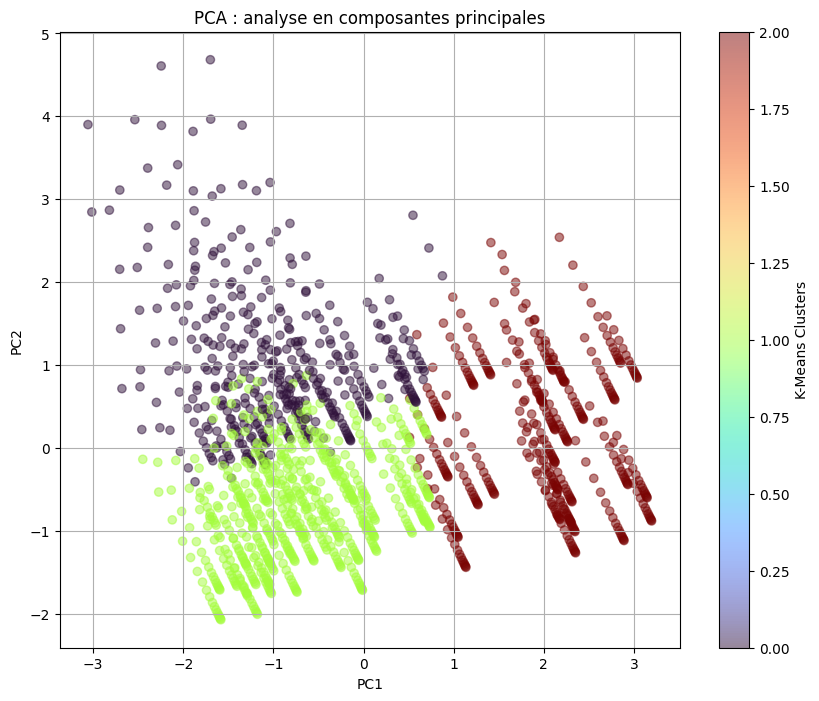

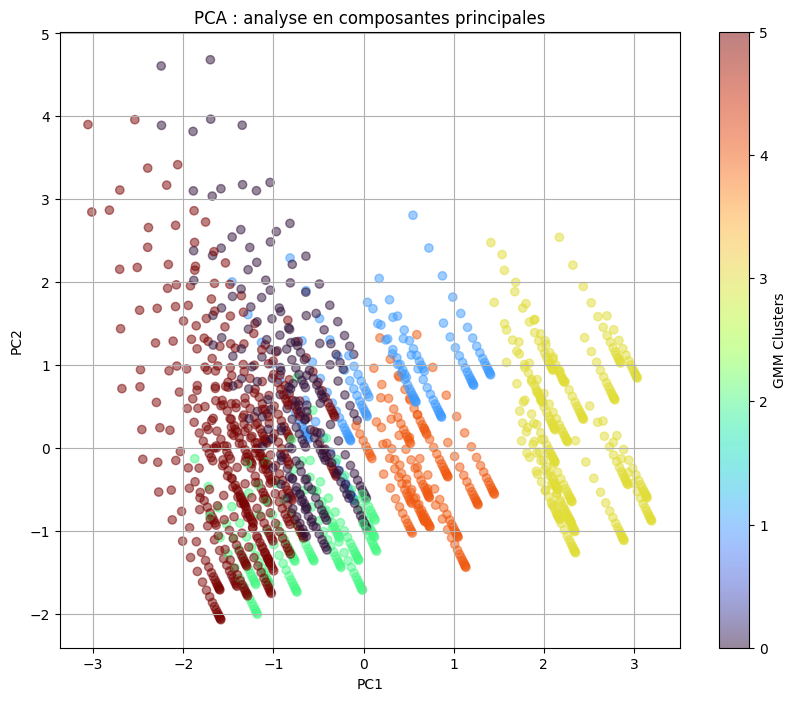

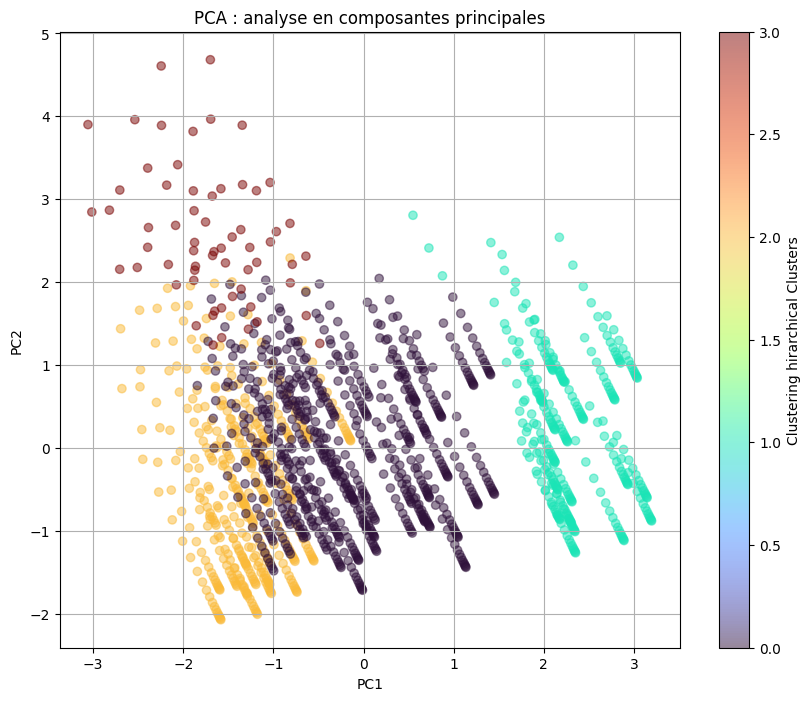

In [48]:
pca(n_components, matrix, preprocessed_data['kmeans_cluster'], "K-Means Clusters")
pca(n_components, matrix, preprocessed_data['gmm_cluster'], "GMM Clusters")
# dbscan
pca(n_components, matrix, preprocessed_data['hierarchical_cluster'], "Clustering hirarchical Clusters")

## Remarques : 

In [49]:
silhouette_avg = silhouette_score(matrix, preprocessed_data['kmeans_cluster'])
print(f"Score de Silhouette K-Means : {silhouette_avg}")


silhouette_avg = silhouette_score(matrix, preprocessed_data['gmm_cluster'])
print(f"Score de Silhouette GMM : {silhouette_avg}")


silhouette_avg = silhouette_score(matrix, preprocessed_data['hierarchical_cluster'])
print(f"Score de Silhouette Hierarchical Clustering : {silhouette_avg}")

Score de Silhouette K-Means : 0.27481054198796623
Score de Silhouette GMM : 0.10847718948398657
Score de Silhouette Hierarchical Clustering : 0.2414186279551342


## Remarques :

* Un score plus élevé indique une meilleure cohésion intra-cluster et une meilleure séparation inter-cluster. Cela implique une meilleure qualité de regroupement.
* Ici K-Means a le meilleure résultat.

In [50]:
dbi_score = davies_bouldin_score(matrix, preprocessed_data['kmeans_cluster'])
print(f"Indice Davies-Bouldin pour K-Means : {dbi_score}")

dbi_score = davies_bouldin_score(matrix, preprocessed_data['gmm_cluster'])
print(f"Indice Davies-Bouldin pour GMM : {dbi_score}")

dbi_score = davies_bouldin_score(matrix, preprocessed_data['hierarchical_cluster'])
print(f"Indice Davies-Bouldin pour Hierarchical Clustering : {dbi_score}")

# Interprétation
# Plus l'indice Davies-Bouldin est bas, meilleure est la qualité du regroupement.
# Une valeur proche de zéro indique des clusters bien séparés.

Indice Davies-Bouldin pour K-Means : 1.4490586605286289
Indice Davies-Bouldin pour GMM : 1.583156648605008
Indice Davies-Bouldin pour Hierarchical Clustering : 1.3096190328431292


## Remarques :

* Un score moins élevé indique une bonne qualité de regroupement.
* Ici aussi K-Means a le meilleur résultat.

# **Clustering hierarchique**

* **Liaison simple (Single Linkage) :** Distance entre deux clusters = distance la plus courte entre les éléments de deux clusters respectifs --> créer des clusters allongés ou chaînés, sensibles au bruit et aux valeurs aberrantes
* **Liaison complète (Complete Linkage) :** Distance entre deux clusters = distance la plus longue entre les éléments de deux clusters respectifs --> former des clusters plus compacts, mieux définis et moins sensibles aux valeurs aberrantes

**Interprétation des résultats avec les dendrogrammes :**
* Observation de la structure des clusters formés à différentes distances
* Comparaison des deux dendrogrammes pour comprendre comment les différents liens (single et complete) influent sur la formation des clusters
* Focalisation sur la compacité, la séparation et la sensibilité aux valeurs aberrantes des clusters générés par les deux méthodes de liaison

In [51]:
def hierarchicalClustering(data, method):
    return linkage(data, method = method)

In [52]:
def graphHierarchicalClustering(data, type_liaison):
    plt.figure(figsize=(12, 4))
    dendrogram(data)
    plt.xlabel('Indice des échantillons')
    plt.ylabel('Distance')
    plt.title(f'Dendrogramme avec liaison {type_liaison}')
    plt.show()

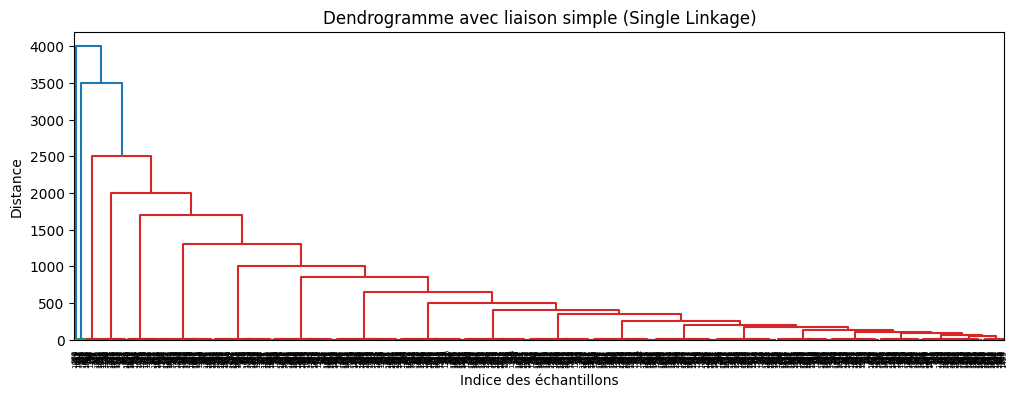

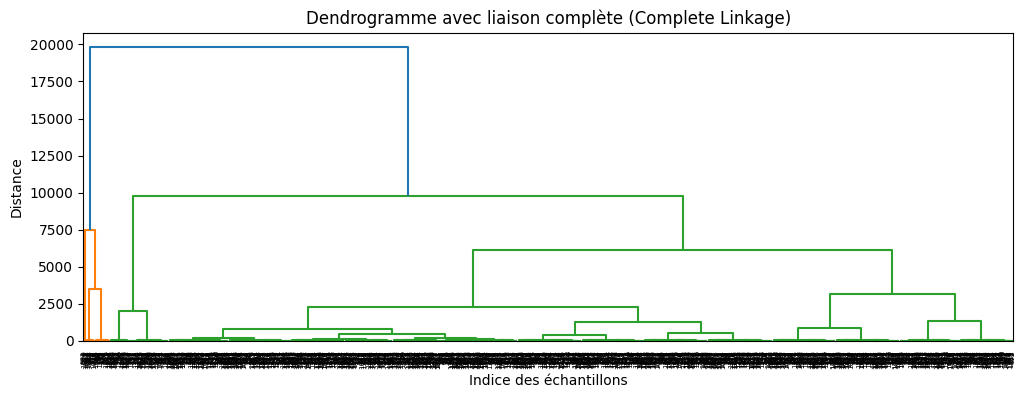

In [53]:
reduced_data = PCA().fit_transform(preprocessed_data)
Z_single = hierarchicalClustering(reduced_data, 'single')
Z_complete = hierarchicalClustering(reduced_data, 'complete')

graphHierarchicalClustering(Z_single, 'simple (Single Linkage)')
graphHierarchicalClustering(Z_complete, 'complète (Complete Linkage)')

## Avantages GMM par rapport à K-Means :

* Analyse des données complexes et mixtes
* Gère plus facilement les valeurs aberrantes

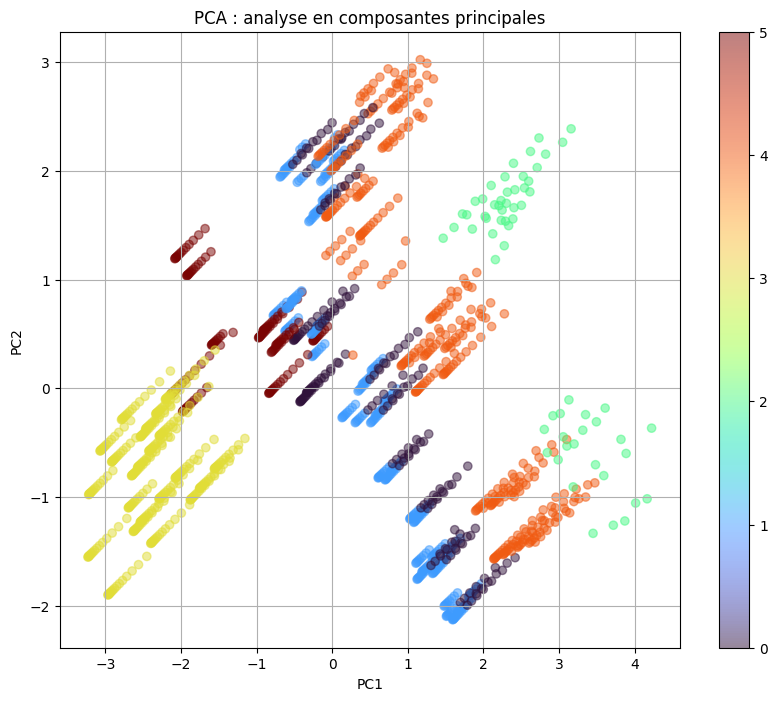

Poids des composants :  [0.14956153 0.22699442 0.04125078 0.23885502 0.24218235 0.10115589]

Moyennes des composants :
[[3.92815085e+03 3.39849182e+00 1.74270916e-01 3.63526127e+01
  4.87211247e-03 1.00000000e+00 2.48433116e+00 6.63310146e-01]
 [1.15846851e+03 2.73709124e+00 1.73614738e-01 4.26519805e+01
  3.32868182e-03 1.00000000e+00 3.24138093e+00 9.64010144e-01]
 [1.27870971e+04 1.59838643e+00 9.79126426e-02 6.27532150e+01
  1.41544588e-03 0.00000000e+00 1.93548001e+00 3.00000000e+00]
 [1.81625467e+03 1.51490382e+01 7.98789272e-02 5.06287184e+01
  3.12655864e-02 2.00000000e+00 3.13091705e+00 8.69082955e-01]
 [3.73915023e+03 3.91043918e+00 1.69914864e-01 6.70857152e+01
  4.34401367e-03 0.00000000e+00 3.01373669e+00 8.76374083e-01]
 [1.67127139e+03 1.00964565e+01 6.72783084e-02 4.75850878e+01
  1.06492413e-02 1.46041923e+00 2.99056836e+00 0.00000000e+00]]

Covariances des composants :
[[[ 5.55874228e+06 -3.06953182e+03 -3.89393182e+01 -4.95736405e+02
   -4.45740658e+00  1.11975157e-2

In [54]:
# Créez et ajustez le modèle GMM
gmm = GaussianMixture(n_components = optimal_gmm, random_state=SEED)
labels = gmm.fit_predict(preprocessed_data)

# Visualisez les composants du GMM
pca(2, preprocessed_data, labels, "")

# Affichez les paramètres des composants du GMM
print("Poids des composants : ", gmm.weights_)
print("\nMoyennes des composants :")
print(gmm.means_)
print("\nCovariances des composants :")
print(gmm.covariances_) 

# **Clustering basé sur la densité**

### **Avantages de DBSCAN :**

* Détection automatique du nombre de clusters : DBSCAN peut détecter automatiquement le nombre de clusters dans les données sans que vous ayez à spécifier ce nombre à l'avance.
* Capacité à gérer des clusters de formes et de densités variables : DBSCAN est efficace pour détecter des clusters de formes arbitraires et de densités variables.
* Identification des points de bruit : DBSCAN peut identifier les points de bruit, ce qui est utile pour la détection d'anomalies.
Pas de nécessité de pré-normalisation : Les données n'ont pas besoin d'être normalisées avant d'appliquer DBSCAN.

### **Inconvénients de DBSCAN :**

* Sensibilité aux hyperparamètres : Le choix des valeurs d'epsilon (eps) et du nombre minimum d'échantillons (min_samples) peut influencer les résultats, et leur réglage peut être délicat.
* Difficulté avec des clusters de densités similaires : DBSCAN peut avoir du mal à distinguer des clusters de densités similaires.
* Complexité en temps : DBSCAN peut être coûteux en termes de temps de calcul pour des ensembles de données très volumineux.

In [55]:
dbscan = DBSCAN(eps = 9000, min_samples = 123)
dbscan_labels = dbscan.fit_predict(reduced_data)

neigh = NearestNeighbors()
neigh.fit(reduced_data)
distances, _ = neigh.kneighbors(reduced_data)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]

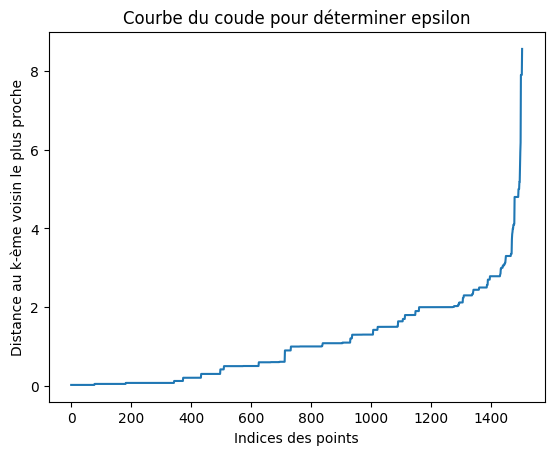

In [56]:
plt.plot(distances)
plt.xlabel('Indices des points')
plt.ylabel(f'Distance au k-ème voisin le plus proche')
plt.title('Courbe du coude pour déterminer epsilon')
plt.show()

In [57]:
def find_optimal_dbscan_parameters(data, eps_values, min_samples_values):
    optimal_eps = None
    optimal_min_samples = None
    optimal_score = -1

    for eps in eps_values:
        for min_samples in min_samples_values:
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            labels = dbscan.fit_predict(data)

            if len(set(labels)) > 1:
                score = silhouette_score(data, labels)
                if score > optimal_score:
                    optimal_eps = eps
                    optimal_min_samples = min_samples
                    optimal_score = score

    return optimal_eps, optimal_min_samples, optimal_score

In [59]:
eps_values = [0.3, 0.5, 0.7]
min_samples_values = [5, 10, 15]

optimal_eps, optimal_min_samples, optimal_score = find_optimal_dbscan_parameters(matrix, eps_values, min_samples_values)

print(f"Optimal Epsilon: {optimal_eps}")
print(f"Optimal Min Samples : {optimal_min_samples}")
print(f"Optimal Silhouette Score : {optimal_score}")

Optimal Epsilon: 0.5
Optimal Min Samples : 5
Optimal Silhouette Score : 0.231187205555197
